In [ ]:
#Initialisation du google drive
from google.colab import drive
drive.mount('/gdrive')

#Lien: https://drive.google.com/drive/folders/1vkE4PW2dqjFF7_bn3R2VIvI6covY3xkh?usp=sharing

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# 1.0.Telechargement et décompression du dataset sélectionné

In [ ]:
#install Kaggle
!pip install -q kaggle

from google.colab import files
files.upload()

#create kaggle folder
!mkdir ~/.kaggle

#copy kaggle.jason ~/.kaggle
! cp kaggle.json ~/.kaggle

#permission for json to act
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download abdallahalidev/plantvillage-dataset
!unzip plantvillage-dataset.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993c-1069b66ce73b___UF.G

#2.Import des packages

In [ ]:
#Librairies communes
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Autres librairies communes utiles au projet
import time, cv2
import os
import glob, cv2
import random
import tensorflow as tf

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#tensorflox
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

#keras
from keras.preprocessing import image


#3.Preprocessing



### Initialisation des chemins et des classes

In [ ]:
#Initialisation des chemins pour aller chercher les images dans le google drive
#chemin_image = '/gdrive/MyDrive/epyphyte/donnees/plantvillage_dataset/color'
chemin_image = 'plantvillage dataset/color'
chemin_image_segmented = 'plantvillage dataset/segmented'
chemin_image_fond = '/gdrive/MyDrive/epyphyte/donnees/photos_reelles/Fonds'
chemin_image_test = '/gdrive/MyDrive/epyphyte/donnees/test'  # 53 photos réelles
chemin_image_test2 = '/gdrive/MyDrive/epyphyte/donnees/test2' # 53 photos color
chemin_image_test3 = '/gdrive/MyDrive/epyphyte/donnees/test3' # 53 photos segmented
checkpoint_filepath = '/gdrive/MyDrive/epyphyte/entrainement/checkpoints/VGG16_avec_transfer_learning_v2'
path_segmented='/gdrive/MyDrive/epyphyte/donnees/plantvillage_dataset/segmented'
path_color='/gdrive/MyDrive/epyphyte/donnees/plantvillage_dataset/color'
path_fond='/gdrive/MyDrive/epyphyte/donnees/photos_reelles/Fonds/Fond_01.jpg'

#Paramètres de modélisation               
largeur = 224
hauteur = 224
profondeur = 3
EPOCHS = 30
batch_size = 32

#Dictionnaires liens numéros <> classes
df = pd.read_csv('/gdrive/MyDrive/epyphyte/donnees/info_maladie.csv', sep=';')

def dataframe_to_dictionnary(dataframe, cle, valeur):
  # Renvoie un dictionnaire à partir de 2 colonnes d'un dataframe
  df_temp = dataframe[[cle, valeur]].set_index(cle)
  return df_temp[valeur].to_dict()

CLASSES = dataframe_to_dictionnary(df, 'dossier', 'classe')
reversed_classes = dataframe_to_dictionnary(df, 'classe', 'dossier')

nb_classes = len(CLASSES)
print("Le nombre de classes est: ",nb_classes)

Le nombre de classes est:  38


In [ ]:
#Construction du DataFrame avec le chemin des images et les catégories
df_chemin = pd.DataFrame()
for (repertoire, sousRepertoires, fichiers) in os.walk(path_segmented):
    df_temp = pd.DataFrame(data=fichiers, columns=['fichier'])
    df_temp['dossier'] = repertoire
    df_chemin = pd.concat([df_chemin, df_temp], axis = 0)

df_chemin['chemin_segmented'] = df_chemin['dossier'] +'/'+ df_chemin['fichier']

df_chemin['dossier']=df_chemin['dossier'].apply(lambda x: x[64:])
df_chemin['plante_maladie']=df_chemin['dossier'].apply(lambda x: x.split('/')[0])
df_chemin['plante']=df_chemin['plante_maladie'].apply(lambda x: x.split('___')[0])
df_chemin['maladie']=df_chemin['plante_maladie'].apply(lambda x: x.split('___')[1])

df_chemin = df_chemin.drop('dossier', axis=1)
df_chemin = df_chemin.drop('fichier', axis=1)

df_chemin['chemin_color']=df_chemin['chemin_segmented'].apply(lambda x: x.replace("segmented","color",1))
df_chemin['chemin_color']=df_chemin['chemin_color'].apply(lambda x: x.replace("_final_masked","",1))
df_chemin['chemin_color']=df_chemin['chemin_color'].apply(lambda x: x.replace("jpg","JPG",1))

df_chemin.head()

,chemin_segmented,plante_maladie,plante,maladie,chemin_color
0,/gdrive/MyDrive/epyphyte/donnees/plantvillage_...,Apple___Cedar_apple_rust,Apple,Cedar_apple_rust,/gdrive/MyDrive/epyphyte/donnees/plantvillage_...
1,/gdrive/MyDrive/epyphyte/donnees/plantvillage_...,Apple___Cedar_apple_rust,Apple,Cedar_apple_rust,/gdrive/MyDrive/epyphyte/donnees/plantvillage_...
2,/gdrive/MyDrive/epyphyte/donnees/plantvillage_...,Apple___Cedar_apple_rust,Apple,Cedar_apple_rust,/gdrive/MyDrive/epyphyte/donnees/plantvillage_...
3,/gdrive/MyDrive/epyphyte/donnees/plantvillage_...,Apple___Cedar_apple_rust,Apple,Cedar_apple_rust,/gdrive/MyDrive/epyphyte/donnees/plantvillage_...
4,/gdrive/MyDrive/epyphyte/donnees/plantvillage_...,Apple___Cedar_apple_rust,Apple,Cedar_apple_rust,/gdrive/MyDrive/epyphyte/donnees/plantvillage_...


### Gestion des fonds

In [ ]:
liste_img_fond = []

#Recherche et chagement de la liste des images de fonds
for fichier in glob.glob(chemin_image_fond + '/**/*.*', recursive=True):
  img_fond = cv2.imread(fichier)
  img_fond = cv2.cvtColor(img_fond, cv2.COLOR_BGR2RGB)
  img_fond = cv2.resize(img_fond, (largeur,hauteur))
  liste_img_fond.append(img_fond)

#Définition de la fonction de preprocessing pour remplacer les fonds noir par l'image de fond
def preprocess_input2(img):
  img = np.where(img <= 10, random.choice(liste_img_fond), img)
  return preprocess_input(img)


###Visualisation des données

chemin color =  /gdrive/MyDrive/epyphyte/donnees/plantvillage_dataset/color/Apple___Cedar_apple_rust/4d7f4b74-59f6-431e-afa3-6fbbb9ac90ea___FREC_C.Rust 0145.JPG
chemin segmented =  /gdrive/MyDrive/epyphyte/donnees/plantvillage_dataset/segmented/Apple___Cedar_apple_rust/4d7f4b74-59f6-431e-afa3-6fbbb9ac90ea___FREC_C.Rust 0145_final_masked.jpg


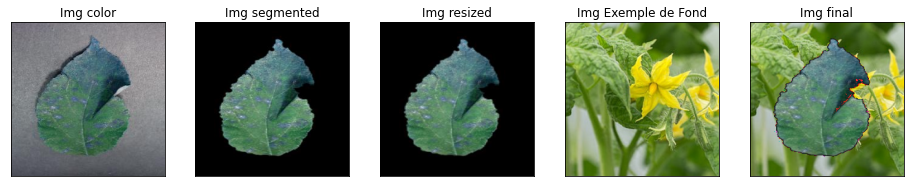

In [ ]:
#Visualisation de la segmentation
fig = plt.figure(figsize = (16,12))

rdm=random.randint(0,len(df))

#Affichage d'une image aléatoire
print("chemin color = ",df_chemin.iloc[rdm]['chemin_color'])
print("chemin segmented = ",df_chemin.iloc[rdm]['chemin_segmented'])
img_color = cv2.imread(df_chemin.iloc[rdm]['chemin_color'],cv2.IMREAD_COLOR)
img_segmented = cv2.imread(df_chemin.iloc[rdm]['chemin_segmented'], cv2.IMREAD_COLOR)
img_mod = cv2.resize(img_segmented, (largeur,hauteur))
img_fond = cv2.imread(path_fond,cv2.IMREAD_COLOR)
img_fond = cv2.cvtColor(img_fond, cv2.COLOR_BGR2RGB)
img_fond = cv2.resize(img_fond, (largeur,hauteur))
img_mod = cv2.resize(img_segmented, (largeur,hauteur))

fig.add_subplot(1,5,1)
plt.imshow(img_color)
plt.xticks([])
plt.yticks([])
plt.title('Img color')

fig.add_subplot(1,5,2)
plt.imshow(img_segmented)#cmap='gray'
plt.xticks([])
plt.yticks([])
plt.title('Img segmented')

fig.add_subplot(1,5,3)
plt.imshow(img_mod)#cmap='gray'
plt.xticks([])
plt.yticks([])
plt.title('Img resized')

fig.add_subplot(1,5,4)
plt.imshow(img_fond)
plt.xticks([])
plt.yticks([])
plt.title('Img Exemple de Fond')

#Utilisation de tf.where pour remplacer le fond noir de l'image segmenté
tf_mod = tf.Variable(img_mod)
tf_fond = tf.Variable(img_fond)
tf_final = tf.where(tf_mod<10,tf_fond,tf_mod) 
#tf_final= preprocess_input2(img_mod)

fig.add_subplot(1,5,5)
plt.imshow(tf_final)
plt.xticks([])
plt.yticks([])
plt.title('Img final')

plt.show()

Sur l'image finale, on peut constater un liseré autour de la feuille.

Ce liseré pourrait biaiser notre modèle.

#4.ImageDataGenerator

In [ ]:
#Chargement des données d'entrées par l'utilisation d'ImageDataGenerator pour éviter les problèmes de mémoire
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input2,
                                          #rotation_range = 10,
                                          #width_shift_range = 0.1,
                                          #height_shift_range = 0.1,
                                          #zoom_range = 1.1,
                                          horizontal_flip = True,
                                          vertical_flip = True,
                                          #rescale=1/255.,  # probablement déjà dans preprocess_input
                                          validation_split=0.2,
                                          )

valid_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input2,
                                          #rescale=1/255.,  # probablement déjà dans preprocess_input
                                          validation_split=0.2)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = train_data_generator.flow_from_directory(directory = chemin_image_segmented,
                                                           classes = CLASSES,
                                                           subset = 'training',
                                                           seed = 7,
                                                           class_mode = 'sparse',
                                                           target_size = (largeur, hauteur), 
                                                           batch_size = batch_size)

valid_generator = valid_data_generator.flow_from_directory(directory = chemin_image_segmented,
                                                           classes = CLASSES,
                                                           subset = 'validation',
                                                           seed = 7,
                                                           class_mode = 'sparse',
                                                           target_size = (largeur, hauteur), 
                                                           batch_size = batch_size)

Found 43457 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


#5.Création du modèle

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False) 
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(GlobalAveragePooling2D()) 
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])


58900480/58889256 [==============================] - 1s 0us/step


#6.Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

earling_stopping = EarlyStopping(monitor='val_loss',
                                 min_delta = 0.01, 
                                 patience = 5, 
                                 mode='min',
                                 restore_best_weights=True,
                                 verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         patience=3,
                                         min_delta=0.01,
                                         factor=0.5, 
                                         cooldown = 4, 
                                         verbose = 1)

checkpoint = ModelCheckpoint(checkpoint_filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max')

#7.Entraînement

In [ ]:
history = model.fit_generator(generator=train_generator, 
                              epochs = EPOCHS,
                              steps_per_epoch = 1310//batch_size,
                              validation_data = valid_generator,
                              validation_steps = 334//batch_size,
                              callbacks = [earling_stopping, 
                                           reduce_learning_rate,
                                           checkpoint
                                          ],
                              verbose = True,
                              )

model.save('/gdrive/MyDrive/epyphyte/entrainement/modeles/VGG16_avec_transfer_learning_v2/')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: 3.0723 - acc: 0.3055
Epoch 00001: saving model to /gdrive/MyDrive/epyphyte/entrainement/checkpoints/VGG16_avec_transfer_learning_v2
INFO:tensorflow:Assets written to: /gdrive/MyDrive/epyphyte/entrainement/checkpoints/VGG16_avec_transfer_learning_v2/assets
40/40 [==============================] - 39s 486ms/step - loss: 3.0723 - acc: 0.3055 - val_loss: 1.9695 - val_acc: 0.4594 - lr: 0.0010
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: 1.8575 - acc: 0.4953
Epoch 00002: saving model to /gdrive/MyDrive/epyphyte/entrainement/checkpoints/VGG16_avec_transfer_learning_v2
INFO:tensorflow:Assets written to: /gdrive/MyDrive/epyphyte/entrainement/checkpoints/VGG16_avec_transfer_learning_v2/assets
40/40 [==============================] - 17s 426ms/step - loss: 1.8575 - acc: 0.4953 - val_loss: 1.4706 - val_acc: 0.5938 - lr: 0.0010
Epoch 3/30
40/40 [==============================] - ETA: 0s - loss: 1.5642 - acc: 

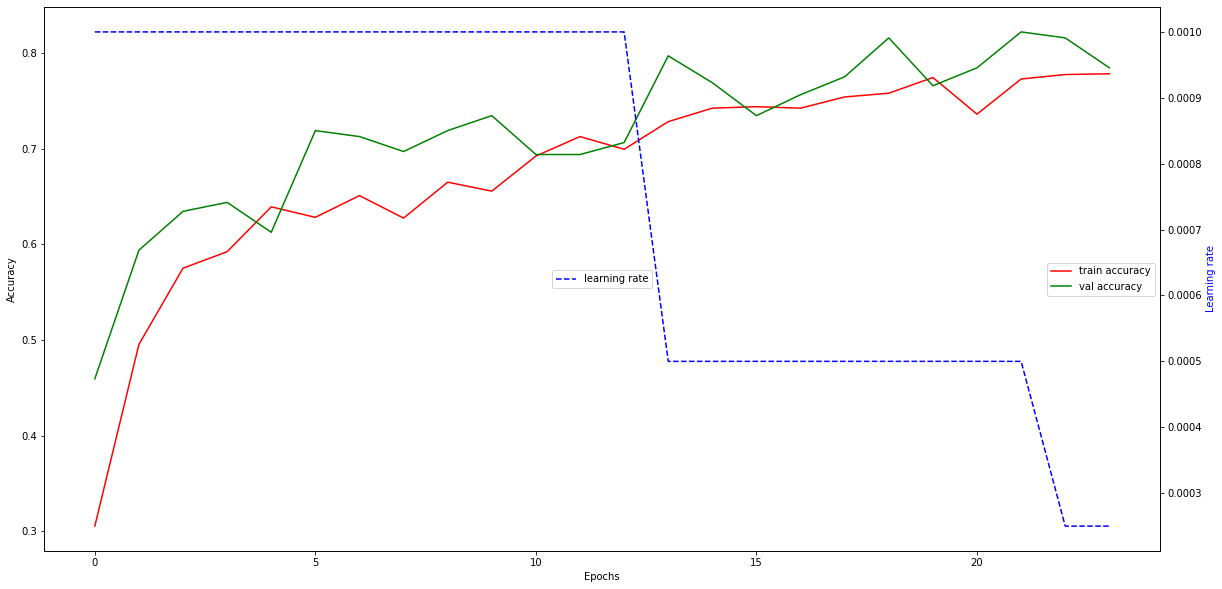

In [ ]:
#Affichage des données d'entrainement du modèle VGG16
fig, ax1 = plt.subplots(figsize=(20,10))

ax2 = ax1.twinx()
ax1.plot(history.history['acc'], label='train accuracy', color='red')
ax1.plot(history.history['val_acc'], label='val accuracy', color='green')
ax2.plot(history.history['lr'], '--', label='learning rate', color='blue')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='k')
ax2.set_ylabel('Learning rate', color='b')

ax1.legend(loc='center right')
ax2.legend(loc='center')
plt.show()


#8.Evaluation

##Chargement du modèle

In [ ]:
model = load_model('/gdrive/MyDrive/epyphyte/entrainement/modeles/VGG16_avec_transfer_learning_v2/')

##Prédictions

In [ ]:
#Initialisation des listes vides
liste_num_classe_reelle = []
liste_num_classe_pred = []
liste_photo = []

#Chargement des images de test et la classe associée
i = 0
for fichier in glob.glob(chemin_image_test + '/**/*.jpg', recursive=True,):
    i += 1

    img = image.load_img(fichier, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    num_classe_pred = model.predict(x).argmax(axis = 1)[0]
    liste_num_classe_pred.append(num_classe_pred)

    chemin = os.path.split(fichier)[0]
    nom_classe_reelle = os.path.split(chemin)[1]
    num_classe_reelle = CLASSES[nom_classe_reelle]
    liste_num_classe_reelle.append(num_classe_reelle)

    liste_photo.append(img)


# Chargement d'informations complémentaires sur les classes
result = pd.DataFrame()
result['reel'] = liste_num_classe_reelle
result['pred'] = liste_num_classe_pred
result['image'] = liste_photo

result = pd.merge(result, df, left_on=['reel'], right_on=['classe'])[['reel','pred','image','dossier','plante_francais']]
result = result.rename({'dossier' : 'nom_classe_reelle',
                        'plante_francais' : 'plante_reelle'}, axis = 1)

result = pd.merge(result, df, left_on=['pred'], right_on=['classe'])[['reel','pred','image','nom_classe_reelle', 'plante_reelle','dossier','plante_francais']]
result = result.rename({'dossier' : 'nom_classe_pred',
                        'plante_francais' : 'plante_pred'}, axis = 1)

result


,reel,pred,image,nom_classe_reelle,plante_reelle,nom_classe_pred,plante_pred
0,21,4,<PIL.Image.Image image mode=RGB size=224x224 a...,Potato___Late_blight,Pomme de terre,Blueberry___healthy,Myrtille
1,21,30,<PIL.Image.Image image mode=RGB size=224x224 a...,Potato___Late_blight,Pomme de terre,Tomato___Late_blight,Tomate
2,21,30,<PIL.Image.Image image mode=RGB size=224x224 a...,Potato___Late_blight,Pomme de terre,Tomato___Late_blight,Tomate
3,29,30,<PIL.Image.Image image mode=RGB size=224x224 a...,Tomato___Early_blight,Tomate,Tomato___Late_blight,Tomate
4,29,30,<PIL.Image.Image image mode=RGB size=224x224 a...,Tomato___Early_blight,Tomate,Tomato___Late_blight,Tomate
5,29,30,<PIL.Image.Image image mode=RGB size=224x224 a...,Tomato___Early_blight,Tomate,Tomato___Late_blight,Tomate
6,29,30,<PIL.Image.Image image mode=RGB size=224x224 a...,Tomato___Early_blight,Tomate,Tomato___Late_blight,Tomate
7,21,29,<PIL.Image.Image image mode=RGB size=224x224 a...,Potato___Late_blight,Pomme de terre,Tomato___Early_blight,Tomate
8,31,31,<PIL.Image.Image image mode=RGB size=224x224 a...,Tomato___Leaf_Mold,Tomate,Tomato___Leaf_Mold,Tomate
9,31,31,<PIL.Image.Image image mode=RGB size=224x224 a...,Tomato___Leaf_Mold,Tomate,Tomato___Leaf_Mold,Tomate


##Evaluation par classe

In [ ]:
pd.crosstab(result['reel'], result['pred'], rownames=['Classe réelle'], colnames=['Classe prédite'], margins=True)

Classe prédite,0,1,3,4,6,11,12,16,25,26,28,29,30,31,32,37,All
Classe réelle,,,,,,,,,,,,,,,,,
0,1,2,3,0,0,0,0,0,0,0,1,0,0,0,0,0,7
11,0,1,0,0,0,3,1,0,0,1,0,0,0,0,1,0,7
21,0,0,0,1,0,0,0,0,0,0,0,1,2,0,0,0,4
25,1,0,1,0,0,1,0,2,3,1,0,0,0,0,0,0,9
28,0,0,0,0,0,0,0,2,0,1,0,0,0,0,3,0,6
29,0,0,1,0,1,0,0,4,0,0,1,0,4,1,1,1,14
31,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,2,6
All,2,3,5,1,1,4,1,8,4,3,3,1,6,3,5,3,53


In [ ]:
print(classification_report(result['nom_classe_reelle'], result['nom_classe_pred']))

                                   precision    recall  f1-score   support

               Apple___Apple_scab       0.50      0.14      0.22         7
                Apple___Black_rot       0.00      0.00      0.00         0
                  Apple___healthy       0.00      0.00      0.00         0
              Blueberry___healthy       0.00      0.00      0.00         0
Cherry_(including_sour)___healthy       0.00      0.00      0.00         0
                Grape___Black_rot       0.75      0.43      0.55         7
     Grape___Esca_(Black_Measles)       0.00      0.00      0.00         0
           Peach___Bacterial_spot       0.00      0.00      0.00         0
             Potato___Late_blight       0.00      0.00      0.00         4
          Squash___Powdery_mildew       0.75      0.33      0.46         9
         Strawberry___Leaf_scorch       0.00      0.00      0.00         0
          Tomato___Bacterial_spot       0.00      0.00      0.00         6
            Tomato___Ear

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

##Evaluation par plante

In [ ]:
pd.crosstab(result['plante_reelle'], result['plante_pred'], rownames=['Plante réelle'], colnames=['Plante prédite'], margins=True)

Plante prédite,Cerise,Courge,Fraise,Myrtille,Pomme,Pêche,Tomate,Vigne,All
Plante réelle,,,,,,,,,
Courge,0,3,1,0,2,2,0,1,9
Pomme,0,0,0,0,6,0,1,0,7
Pomme de terre,0,0,0,1,0,0,3,0,4
Tomate,1,1,1,0,1,6,16,0,26
Vigne,0,0,1,0,1,0,1,4,7
All,1,4,3,1,10,8,21,5,53


In [ ]:
print(classification_report(result['plante_reelle'], result['plante_pred']))

                precision    recall  f1-score   support

        Cerise       0.00      0.00      0.00         0
        Courge       0.75      0.33      0.46         9
        Fraise       0.00      0.00      0.00         0
      Myrtille       0.00      0.00      0.00         0
         Pomme       0.60      0.86      0.71         7
Pomme de terre       0.00      0.00      0.00         4
         Pêche       0.00      0.00      0.00         0
        Tomate       0.76      0.62      0.68        26
         Vigne       0.80      0.57      0.67         7

      accuracy                           0.55        53
     macro avg       0.32      0.26      0.28        53
  weighted avg       0.69      0.55      0.59        53



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

##Affichage des photos bien classées

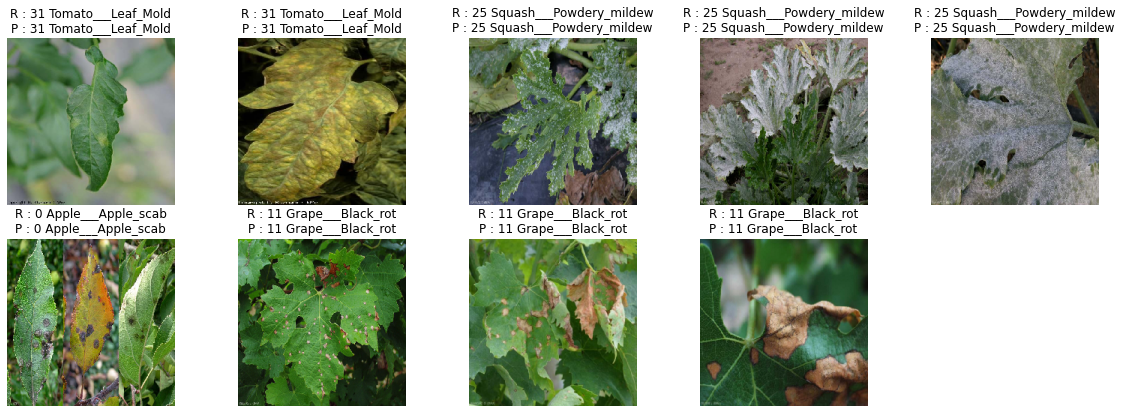

In [ ]:
plt.figure( figsize= (20,40) ) 
k = 0
for i in range(len(result)):
    num_classe_reelle = result.loc[i, 'reel']
    num_classe_pred = result.loc[i, 'pred']

    if num_classe_reelle == num_classe_pred:
        nom_classe_reelle = result.loc[i, 'nom_classe_reelle']
        nom_classe_pred = result.loc[i, 'nom_classe_pred']
        img = result.loc[i, 'image']

        k += 1
        plt.subplot(11,5,k)
        plt.imshow(img)
        plt.axis('off')
        plt.title('R : ' + str(num_classe_reelle) + ' ' + nom_classe_reelle + '\n' + 'P : ' + str(num_classe_pred) + ' ' + nom_classe_pred)

##Affichage des photos mal classées

In [ ]:
plt.figure( figsize= (20,40) ) 
k = 0
for i in range(len(result)):
    num_classe_reelle = result.loc[i, 'reel']
    num_classe_pred = result.loc[i, 'pred']

    if num_classe_reelle != num_classe_pred:
        nom_classe_reelle = result.loc[i, 'nom_classe_reelle']
        nom_classe_pred = result.loc[i, 'nom_classe_pred']
        img = result.loc[i, 'image']

        k += 1
        plt.subplot(11,5,k)
        plt.imshow(img)
        plt.axis('off')
        plt.title('R : ' + str(num_classe_reelle) + ' ' + nom_classe_reelle + '\n' + 'P : ' + str(num_classe_pred) + ' ' + nom_classe_pred)



Output hidden; open in https://colab.research.google.com to view.

Pour le mildiou de la tomate, on peut remarquer qu'à 4 reprises, le modèle ne se trompe que sur l'état avancé ou non de la maladie. 
Il faudrait peut-être envisager la fusion des classes :
- Tomato___Early_blight et Tomato___Late_blight
- Potato___Early_blight et Potato___Late_blight

#Conclusion

Dans le cadre de ce sprint (modélisation N°2), nous avons mis en place un modèle de deep learning avec transfert learning basé sur l'architecture VGG16.

Ce modèle a été entrainé sur 3 jeux de données différents:
  1. Les données originales dites "color" ou "test" où les photos de feuilles sont prises sur des fonds unis.
  2. Les données segmentées dites "segmented" ou "test2" récupérées depuis le dataset "plantvillage dataset" de kaggle, où le fond original est remplacé par un fond noir.
  3. Les données segmentées avec le fond noir remplacé par des photos de jardins aléatoirement dites "filled" ou "test3" pour limiter le biais et améliorer le modèle par rapport à l'objectif final. 

Malheureusement dans les 3 cas les modèles présentent des résultats safisfaisant seulement sur les données d'entrées mais pas sur des données réelles: accurracy de 0.17 sur les couples plantes maladies.

Par contre les résultats sur la classification du type de plante montre un bien meilleur résultat : accurracy de 0.55.

Voici les pistes d'amélioration pour les prochains sprints:
 - Tester d'autres modèles de Deep Learning.
 - Améliorer le preprocessing pour enlever le liseré autour de la feuille segmentée intégrée dans une image de fond.
 - Améliorer l'augmentation de données pour réquilibrer les classes.
 - Ajouter une augmentation de données pour les fonds
 - Créer un modèle de détection de plante puis un modèle de détection de maladie.
 - Fusionner les classes Tomato___Early_blight / Tomato___Late_blight, 
Potato___Early_blight / Potato___Late_blight
